# Tables and Figures: Code
### Create the manuscript’s tables and figures using aggregated outputs from every model

**Inputs:** CSV result files per model (see `results/raw_results/`)

In [ ]:
import re
import string
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
import warnings

warnings.filterwarnings("ignore")


# Set visual style
sns.set(style="whitegrid")
BASE = "X" # Add your base folder

## 1. Data loading

In [2]:
overlap_semantic = f"{BASE}/results/raw_results/overlap_semantic/results_overlap_cosine_large.csv"

p_roberta = f"{BASE}/results/raw_results/overlap_semantic/results_bertscore_bleurt_roberta.csv"
p_xlmr = f"{BASE}results/raw_results/overlap_semantic/results_bertscore_bleurt_xlmr_base.csv"

# Load and merge all LLM evaluation files
llm_files = {
    f"{BASE}results/raw_results/LLMs/results_gemma3_gemma3n_e2b.csv": "Gemma3n E2B",
    f"{BASE}results/raw_results/LLMs/results_gemma3_gemma3n_e4b.csv": "Gemma3n E4B",
    f"{BASE}results/raw_results/LLMs/results_DeepSeek-R1-0528.csv": "DeepSeek R1",
    f"{BASE}results/raw_results/LLMs/results_llm_gpt-35.csv": "gpt 3.5",
    f"{BASE}results/raw_results/LLMs/results_llm_gpt-4.csv": "gpt 4",
    f"{BASE}results/raw_results/LLMs/results_gpt-4.1.csv": "gpt-4.1",
    f"{BASE}results/raw_results/LLMs/results_gpt-4o.csv": "gpt-4o",
    f"{BASE}results/raw_results/LLMs/results_gpt-5.csv": "gpt-5",
    f"{BASE}results/raw_results/LLMs/results_gpt-5-mini.csv": "gpt-5 mini",
    f"{BASE}results/raw_results/LLMs/results_gpt-5-nano.csv": "gpt-5 nano",
    f"{BASE}results/raw_results/LLMs/results_llm_gpt_oss_120b.csv": "gpt-oss-120b",
    f"{BASE}results/raw_results/LLMs/results_llm_gpt_oss_20b_5000.csv": "gpt-oss-20b",
}


In [3]:
# Load cosine data
df_overlap_semantic = pd.read_csv(overlap_semantic, delimiter=";")

# Tag the model
df_overlap_semantic["model"] = "OpenAI Large"
df_overlap_semantic.rename(columns=lambda c: c.strip().lower(), inplace=True)

# Combine embedding-based models
df_all = df_overlap_semantic.copy()

# Normalize variation type
def normalize_type(row):
    for level in ["1", "2", "3"]:
        if f"delete_{level}" in row["file"]:
            return f"delete_{level}"
        elif f"mod_{level}" in row["file"]:
            return f"mod_{level}"
        elif f"synonyms_{level}" in row["file"]:
            return f"synonyms_{level}"
    return row["type"]

# Function to extract numeric score from LLM output
def extract_llm_score(val):
    if isinstance(val, (int, float)):
        return val
    if isinstance(val, str):
        numbers = re.findall(r"\d+", val)
        if numbers:
            return int(numbers[-1])  # Fallback: last number
    return None

df_all["variation"] = df_all.apply(normalize_type, axis=1)
df_all["variation_type"] = df_all["variation"].str.extract(r"([a-z]+)")
df_all["variation_level"] = df_all["variation"].str.extract(r"(\d+)").astype(int)


for path, label in llm_files.items():
    df_tmp = pd.read_csv(path).copy()
    df_tmp[label] = df_tmp["llm_evaluation"].apply(extract_llm_score)

    # Ensure variation columns are present
    if "variation" not in df_tmp.columns:
        df_tmp["variation"] = df_tmp.apply(normalize_type, axis=1)
        df_tmp["variation_type"] = df_tmp["variation"].str.extract(r"([a-z]+)")
        df_tmp["variation_level"] = (
            df_tmp["variation"].str.extract(r"(\d+)").astype(int)
        )

    # Merge into df_all
    df_all = df_all.merge(
        df_tmp[["file", "language", "variation", label]],
        on=["file", "language", "variation"],
        how="left",
    )

# Final dataframe
print("Final merged dataframe shape:", df_all.shape)
df_all.head()

Final merged dataframe shape: (135, 27)


,case,language,type,file,cosine_similarity,bleu_score,rouge_1,rouge_2,rouge_3,rouge_4,...,DeepSeek R1,gpt 3.5,gpt 4,gpt-4.1,gpt-4o,gpt-5,gpt-5 mini,gpt-5 nano,gpt-oss-120b,gpt-oss-20b
0,medicine_3,english,delete,Case_3_Medicine_English_delete_3.csv,0.974889,0.827079,0.917808,0.886598,0.855172,0.823529,...,11,7,12,8,12,14,13,12,13,12.0
1,medicine_3,english,delete,Case_3_Medicine_English_delete_2.csv,0.982768,0.872446,0.936027,0.915541,0.894915,0.874150,...,8,3,5,8,7,10,9,8,7,6.0
2,medicine_3,english,delete,Case_3_Medicine_English_delete_1.csv,0.987810,0.932739,0.970684,0.954248,0.937705,0.924342,...,4,1,4,6,7,5,5,4,5,NaN
3,medicine_3,english,modify,Case_3_Medicine_English_summary_mod_2.csv,0.967065,0.908575,0.943038,0.898413,0.869427,0.846645,...,8,6,9,8,8,10,9,9,9,10.0
4,medicine_3,english,modify,Case_3_Medicine_English_summary_mod_3.csv,0.957931,0.858203,0.924031,0.874028,0.842434,0.816901,...,10,11,8,10,11,13,12,12,12,12.0


In [4]:
# Helpers
def norm_lang(x):
    return str(x).strip().lower()


def parse_variation_from_filename(fname):
    """Return (variation_type, variation_level) from a filename."""
    if not isinstance(fname, str):
        return None, None
    # Handle ..._delete_2.csv, ..._synonyms_3.csv, ..._mod_2.csv, ..._modify_2.csv
    m = re.search(r"_(delete|synonyms|mod(?:ify)?)_(\d+)\.csv$", fname, flags=re.I)
    if m:
        vtype = m.group(1).lower()
        if vtype == "mod":
            vtype = "modify"
        level = int(m.group(2))
        return vtype, level
    # Originals
    if fname.lower().endswith("_summary.csv"):
        return "original", 0
    return None, None


def ensure_keys(df, source_name):
    """Ensure language, variation_type, variation_level exist and align."""
    out = df.copy()

    # Language
    if "language" in out.columns:
        out["language"] = out["language"].map(norm_lang)

    # Ensure 'variation_type'
    if "variation_type" not in out.columns:
        if "type" in out.columns:
            out = out.rename(columns={"type": "variation_type"})
        else:
            out["variation_type"] = None

    # Variation_level from filename when missing or zero
    if "variation_level" not in out.columns:
        out["variation_level"] = None

    # Parse from filename for all rows
    vt, vl = zip(*out["file"].map(parse_variation_from_filename))
    out["variation_type_from_file"] = vt
    out["variation_level_from_file"] = vl

    # Prefer parsed values when available
    out["variation_type"] = out["variation_type"].fillna(
        out["variation_type_from_file"]
    )
    out["variation_level"] = out["variation_level"].fillna(
        out["variation_level_from_file"]
    )

    # Normalize 'mod' => 'modify'
    out["variation_type"] = out["variation_type"].replace({"mod": "modify"})

    # cast level to integer where possible
    out["variation_level"] = (
        pd.to_numeric(out["variation_level"], errors="coerce").fillna(0).astype(int)
    )

    # Cleaning
    out = out.drop(columns=["variation_type_from_file", "variation_level_from_file"])

    # Small sanity
    missing_mask = out["variation_type"].isna()
    if missing_mask.any():
        print(
            f"[{source_name}] Warning: {missing_mask.sum()} rows have missing variation_type"
        )

    return out


# Load the two files
df_r = pd.read_csv(p_roberta)
df_x = pd.read_csv(p_xlmr)
df_bert_raw = pd.concat([df_r, df_x], ignore_index=True)

# Standardize the new-results frame
df_bert = ensure_keys(df_bert_raw, "new_results")

# Build BLEURT table
bleurt_keys = ["language", "case", "variation_type", "variation_level"]
df_bleurt = (
    df_bert.groupby(bleurt_keys, as_index=False)["bleurt"]
    .mean()
    .rename(columns={"bleurt": "bleurt_score"})
)

# Build BERTScore table per backbone, then pivot wide
if "bertscore_model" not in df_bert.columns:
    df_bert["bertscore_model"] = "unknown"

df_berts = df_bert.groupby(bleurt_keys + ["bertscore_model"], as_index=False)[
    ["bertscore_precision", "bertscore_recall", "bertscore_f1"]
].mean()

df_berts_wide = df_berts.pivot_table(
    index=bleurt_keys,
    columns="bertscore_model",
    values=["bertscore_precision", "bertscore_recall", "bertscore_f1"],
)

# Flatten the MultiIndex columns, no rename_axis needed
df_berts_wide.columns = [
    f"{metric}__{model}".replace(" ", "_")
    for metric, model in df_berts_wide.columns.to_flat_index()
]
df_berts_wide = df_berts_wide.reset_index()


# Normalize df_all keys, then merge
df_base = ensure_keys(df_all, "df_all")

merge_keys = ["language", "case", "variation_type", "variation_level"]

df_all = df_base.merge(df_bleurt, on=merge_keys, how="left").merge(
    df_berts_wide, on=merge_keys, how="left"
)

print("Merged BLEURT and BERTScore into df_all")
df_all


Merged BLEURT and BERTScore into df_all


,case,language,type,file,cosine_similarity,bleu_score,rouge_1,rouge_2,rouge_3,rouge_4,...,gpt-5 nano,gpt-oss-120b,gpt-oss-20b,bleurt_score,bertscore_f1__roberta-large,bertscore_f1__xlm-roberta-base,bertscore_precision__roberta-large,bertscore_precision__xlm-roberta-base,bertscore_recall__roberta-large,bertscore_recall__xlm-roberta-base
0,medicine_3,english,delete,Case_3_Medicine_English_delete_3.csv,0.974889,0.827079,0.917808,0.886598,0.855172,0.823529,...,12,13,12.0,0.053891,0.708575,0.947427,0.731611,0.954096,0.684786,0.940851
1,medicine_3,english,delete,Case_3_Medicine_English_delete_2.csv,0.982768,0.872446,0.936027,0.915541,0.894915,0.874150,...,8,7,6.0,0.053891,0.726115,0.952424,0.732238,0.957102,0.719116,0.947792
2,medicine_3,english,delete,Case_3_Medicine_English_delete_1.csv,0.987810,0.932739,0.970684,0.954248,0.937705,0.924342,...,4,5,NaN,0.345433,0.863063,0.958276,0.863824,0.960326,0.861856,0.956235
3,medicine_3,english,modify,Case_3_Medicine_English_summary_mod_2.csv,0.967065,0.908575,0.943038,0.898413,0.869427,0.846645,...,9,9,10.0,0.598662,0.880526,0.984972,0.884936,0.985435,0.875734,0.984509
4,medicine_3,english,modify,Case_3_Medicine_English_summary_mod_3.csv,0.957931,0.858203,0.924031,0.874028,0.842434,0.816901,...,12,12,12.0,0.417593,0.815999,0.963753,0.825947,0.963975,0.805490,0.963531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,medicine_1,swedish,modify,Case_1_Medicine_Swedish_summary_mod_2.csv,0.959147,0.755908,0.863636,0.757991,0.688073,0.626728,...,12,16,14.0,0.380670,0.962373,0.958012,0.962956,0.959401,0.961791,0.956627
131,medicine_1,swedish,modify,Case_1_Medicine_Swedish_summary_mod_3.csv,0.837832,0.255849,0.562033,0.467766,0.418045,0.377074,...,17,11,NaN,0.294837,0.927135,0.916030,0.927432,0.908050,0.926839,0.924152
132,medicine_1,swedish,synonyms,Case_1_Medicine_Swedish_summary_synonyms_1.csv,0.995568,0.929864,0.972727,0.945205,0.922018,0.898618,...,1,0,0.0,0.445027,0.974665,0.981335,0.973860,0.979124,0.975472,0.983557
133,medicine_1,swedish,synonyms,Case_1_Medicine_Swedish_summary_synonyms_2.csv,0.995342,0.879136,0.943311,0.897494,0.855835,0.818391,...,1,0,0.0,0.069044,0.965666,0.968232,0.964091,0.964598,0.967245,0.971894


### 1.1. Descriptive information

In [5]:
# Prep
df = df_all.copy()

# be safe about level dtype
df["variation_level"] = pd.to_numeric(df["variation_level"], errors="coerce")

# make short alias names
ID_COLS = {
    "case",
    "language",
    "type",
    "file",
    "model",
    "variation",
    "variation_type",
    "variation_level",
    "variation_group",
}

# metrics that are computed per embedding model
PER_MODEL_METRICS = {
    "cosine_similarity",
}

# pick all numeric metric columns
num_cols = [
    c for c in df.columns if c not in ID_COLS and pd.api.types.is_numeric_dtype(df[c])
]

STATIC_METRICS = [c for c in num_cols if c not in PER_MODEL_METRICS]
PERMODEL_METRICS = [c for c in num_cols if c in PER_MODEL_METRICS]

languages = sorted(df["language"].dropna().unique().tolist())
types = sorted(df["type"].dropna().unique().tolist())

print("Found:")
print(f"  Languages: {languages}")
print(f"  Types:     {types}")
print(f"  Static metrics (no 'model' column needed): {len(STATIC_METRICS)}")
print(f"  Per-model metrics: {PERMODEL_METRICS}")
print(
    f"  Unique embedding models in data: {sorted(df['model'].dropna().unique().tolist())}"
)


Found:
  Languages: ['english', 'finnish', 'swedish']
  Types:     ['delete', 'modify', 'synonyms']
  Static metrics (no 'model' column needed): 25
  Per-model metrics: ['cosine_similarity']
  Unique embedding models in data: ['OpenAI Large']


## 2. Linear-mixed model

In [6]:
PREFER_MODEL_FOR_STATIC = "OpenAI Large"  # Which row to keep for overlap metrics, like BLEU and Rouge, as they are in the same df


def _dedup_static_rows(base, prefer_model=PREFER_MODEL_FOR_STATIC):
    """For static metrics: keep one row per (case, level), prefer a chosen model if present."""
    if "model" not in base.columns:
        keep = base.drop_duplicates(subset=["case", "variation_level"]).copy()
        keep["model"] = None
        return keep

    tmp = base.copy()
    # Sort so preferred model is first within each (case, level)
    tmp["_pref"] = (tmp["model"] != prefer_model).astype(int)
    tmp = (
        tmp.sort_values(["case", "variation_level", "_pref"])
        .drop_duplicates(subset=["case", "variation_level"], keep="first")
        .drop(columns="_pref")
    )
    tmp["model"] = None  # Treat as model-agnostic downstream
    return tmp


def fit_lmm_one_slice(
    data, language, ptype, metric_col, model_name=None, treat_level_as="numeric"
):
    """
    Returns: dict with results, or None if the fit is not possible.
    """
    q = "language == @language and type == @ptype and variation_level in [1,2,3]"
    if model_name is not None:
        q += " and model == @model_name"

    base = data.query(q).copy()

    # For static metrics, collapse duplicates to one row per (case, level)
    if model_name is None and metric_col in STATIC_METRICS:
        base = _dedup_static_rows(base, prefer_model=PREFER_MODEL_FOR_STATIC)

    d = (
        base.loc[:, ["case", "variation_level", metric_col]]
        .dropna()
        .rename(columns={"variation_level": "lvl", metric_col: "y"})
        .copy()
    )

    # Keep only cases that have all three levels
    ok = d.groupby("case")["lvl"].nunique()
    d = d[d["case"].isin(ok[ok == 3].index)].copy()

    if d.empty or d["y"].nunique() < 2:
        return None

    formula = "y ~ lvl" if treat_level_as == "numeric" else "y ~ C(lvl)"
    try:
        m = smf.mixedlm(formula, data=d, groups=d["case"])
        res = m.fit(reml=True, method="lbfgs", disp=False)
    except Exception as e:
        return {
            "language": language,
            "type": ptype,
            "metric": metric_col,
            "model": None
            if (model_name is None and metric_col in STATIC_METRICS)
            else model_name,
            "n_rows": len(d),
            "n_cases": d["case"].nunique(),
            "status": f"fit_failed: {type(e).__name__}: {e}",
        }

    out = {
        "language": language,
        "type": ptype,
        "metric": metric_col,
        "model": None
        if (model_name is None and metric_col in STATIC_METRICS)
        else model_name,
        "n_rows": len(d),
        "n_cases": d["case"].nunique(),
        "status": "ok",
        "reml_loglike": res.llf,
        "resid_var": float(getattr(res, "scale", np.nan)),
    }

    try:
        out["rand_intercept_var"] = float(res.cov_re.iloc[0, 0])
    except Exception:
        out["rand_intercept_var"] = np.nan

    out.update(
        {
            "estimate_lvl": res.params.get("lvl", np.nan),
            "se_lvl": res.bse.get("lvl", np.nan),
            "z_or_t_lvl": res.tvalues.get("lvl", np.nan),
            "p_lvl": res.pvalues.get("lvl", np.nan),
        }
    )

    return out

# Run across all languages, types, metrics, and models
results = []

# Static metrics (do not depend on 'model')
for lang in languages:
    for typ in types:
        for metric_col in STATIC_METRICS:
            r = fit_lmm_one_slice(
                df, lang, typ, metric_col, model_name=None, treat_level_as="numeric"
            )
            if r is not None:
                results.append(r)

# Per-model metrics
embed_models = sorted(df["model"].dropna().unique().tolist())
for lang in languages:
    for typ in types:
        for metric_col in PERMODEL_METRICS:
            for mdl in embed_models:
                r = fit_lmm_one_slice(
                    df, lang, typ, metric_col, model_name=mdl, treat_level_as="numeric"
                )
                if r is not None:
                    results.append(r)

lmm_results = pd.DataFrame(results)
print(lmm_results.shape)
lmm_results


(227, 14)


,language,type,metric,model,n_rows,n_cases,status,reml_loglike,resid_var,rand_intercept_var,estimate_lvl,se_lvl,z_or_t_lvl,p_lvl
0,english,delete,bleu_score,None,15,5,ok,20.499459,0.000861,2.331176e-03,-0.083193,0.009280,-8.964982,3.103322e-19
1,english,delete,rouge_1,None,15,5,ok,25.905098,0.000443,6.361147e-04,-0.047633,0.006654,-7.158244,8.171683e-13
2,english,delete,rouge_2,None,15,5,ok,24.330062,0.000555,8.524824e-04,-0.059222,0.007448,-7.951447,1.843454e-15
3,english,delete,rouge_3,None,15,5,ok,22.177448,0.000753,1.281304e-03,-0.071538,0.008675,-8.246388,1.632540e-16
4,english,delete,rouge_4,None,15,5,ok,20.489128,0.000954,1.772464e-03,-0.083436,0.009767,-8.542718,1.311006e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,finnish,modify,cosine_similarity,OpenAI Large,15,5,ok,23.276131,0.001109,1.875401e-11,-0.036734,0.010531,-3.488120,4.864305e-04
223,finnish,synonyms,cosine_similarity,OpenAI Large,15,5,ok,49.989317,0.000006,7.873077e-05,-0.003313,0.000759,-4.363917,1.277539e-05
224,swedish,delete,cosine_similarity,OpenAI Large,15,5,ok,24.688042,0.000657,3.739819e-04,-0.025337,0.008105,-3.126184,1.770905e-03
225,swedish,modify,cosine_similarity,OpenAI Large,15,5,ok,23.448260,0.001059,2.364105e-05,-0.032457,0.010289,-3.154349,1.608569e-03


In [7]:
# Multiple testing correction on the lvl trend (only rows that actually have a numeric lvl effect)
if "p_lvl" in lmm_results.columns:
    mask = lmm_results["p_lvl"].notna()
    if mask.any():
        reject, p_adj, *_ = multipletests(
            lmm_results.loc[mask, "p_lvl"], method="fdr_bh"
        )
        lmm_results.loc[mask, "p_lvl_fdr_bh"] = p_adj
        lmm_results.loc[mask, "sig_fdr_bh"] = reject

# sort for a quick look
display_cols = [
    "language",
    "type",
    "metric",
    "model",
    "n_rows",
    "n_cases",
    "estimate_lvl",
    "se_lvl",
    "z_or_t_lvl",
    "p_lvl",
    "p_lvl_fdr_bh",
    "rand_intercept_var",
    "resid_var",
    "status",
]

lmm_results.sort_values(["metric", "language", "type", "model"]).loc[
    :, [c for c in display_cols if c in lmm_results.columns]
].head(20)

lmm_results.to_csv(f"{BASE}/results/raw_results/linear_mixed_model/raw_linear_mixed_models.csv", index=False)


In [8]:
lmm = pd.read_csv(
    f"{BASE}/results/raw_results/linear_mixed_model/raw_linear_mixed_models.csv"
)

print(len(lmm))

m = lmm_results.copy()
m["metric"] = m["metric"].astype(str).str.lower()
m["model"] = m["model"].astype(str).str.lower()

mask_rouge = m["metric"].eq("rouge_l_score")

mask_bert = (
    m["metric"].eq("bertscore_f1__roberta-large")
    #& m["model"].str.contains(r"\broberta\b")
   # & m["model"].str.contains(r"\blarge\b")
)

mask_gpt5 = m["metric"].eq("gpt-5")

filtered = lmm_results[mask_rouge | mask_bert | mask_gpt5].copy()
print(len(filtered))
filtered.to_csv(
    f"{BASE}/results/raw_results/linear_mixed_model/raw_linear_mixed_models_specific.csv",
    index=False,
)
filtered.head(20)

227
27


,language,type,metric,model,n_rows,n_cases,status,reml_loglike,resid_var,rand_intercept_var,estimate_lvl,se_lvl,z_or_t_lvl,p_lvl,p_lvl_fdr_bh,sig_fdr_bh
5,english,delete,rouge_l_score,None,15,5,ok,25.905098,0.000443,6.361147e-04,-4.763256e-02,0.006654,-7.158244e+00,8.171683e-13,2.638286e-12,True
13,english,delete,gpt-5,None,15,5,ok,-24.756292,1.307410,7.864125e-01,5.700000e+00,0.361581,1.576409e+01,5.495859e-56,1.035053e-54,True
19,english,delete,bertscore_f1__roberta-large,None,15,5,ok,26.009447,0.000459,5.329935e-04,-8.666203e-02,0.006775,-1.279131e+01,1.833451e-37,1.973142e-36,True
30,english,modify,rouge_l_score,None,15,5,ok,13.007984,0.004369,1.412852e-03,-8.976474e-02,0.020903,-4.294435e+00,1.751390e-05,3.044725e-05,True
38,english,modify,gpt-5,None,15,5,ok,-44.119586,29.184955,8.349780e+00,1.000000e+01,1.708360,5.853566e+00,4.811446e-09,1.169233e-08,True
44,english,modify,bertscore_f1__roberta-large,None,15,5,ok,10.179340,0.006707,2.264492e-03,-1.039107e-01,0.025898,-4.012355e+00,6.011588e-05,9.704421e-05,True
55,english,synonyms,rouge_l_score,None,15,5,ok,43.336646,0.000029,5.043074e-05,-2.748237e-02,0.001698,-1.618738e+01,6.191223e-59,1.272015e-57,True
62,english,synonyms,gpt-5,None,15,5,ok,-8.784804,0.153846,2.041351e-34,4.440892e-17,0.124035,3.580362e-16,1.000000e+00,1.000000e+00,False
66,english,synonyms,bertscore_f1__roberta-large,None,15,5,ok,34.839419,0.000093,2.729935e-04,-1.700103e-02,0.003044,-5.585568e+00,2.329382e-08,5.317579e-08,True
77,finnish,delete,rouge_l_score,None,15,5,ok,26.951651,0.000412,4.097720e-04,-5.662725e-02,0.006417,-8.825254e+00,1.092117e-18,5.609510e-18,True


In [9]:
# One row per language × edit type
# Columns: ROUGE-L β (95% CI) | p, BERTScore β (95% CI) | p, GPT-5 β (95% CI) | p

# Inputs/outputs 
OUT_CSV = "Table_2_lmm_fixed_effects.csv"
OUT_XLSX = "Table_2_lmm_fixed_effects.xlsx"

# Load
df = pd.read_csv(
    f"{BASE}/results/raw_results/linear_mixed_model/raw_linear_mixed_models_specific.csv"
)

# Keep only the three representatives and map labels
metric_map = {
    "rouge_l_score": ("ROUGE-L", 3),
    "bertscore_f1__roberta-large": ("BERTScore", 3),
    "gpt-5": ("GPT-5", 2),  # short label for the table
}
df = df[df["metric"].isin(metric_map.keys())].copy()
df["Metric"] = df["metric"].map(lambda m: metric_map[m][0])
df["decimals"] = df["metric"].map(lambda m: metric_map[m][1])

# Edit type labels and ordering
etype_map = {"delete": "Delete", "modify": "Modify", "synonyms": "Paraphrase"}
df["Edit type"] = df["type"].map(etype_map)
lang_order = ["english", "swedish", "finnish"]
type_order = ["Delete", "Modify", "Paraphrase"]
df["language"] = pd.Categorical(df["language"], categories=lang_order, ordered=True)
df["Edit type"] = pd.Categorical(df["Edit type"], categories=type_order, ordered=True)

# Compute CI and p 
z = 1.96
df["ci_low"] = df["estimate_lvl"] - z * df["se_lvl"]
df["ci_high"] = df["estimate_lvl"] + z * df["se_lvl"]

# p-value: use provided column if present, otherwise normal approximation
df["p_value"] = df["p_lvl"]

# Formatters 
def fmt_beta_ci(beta, lo, hi, decimals):
    return f"{beta:.{decimals}f} ({lo:.{decimals}f} to {hi:.{decimals}f})"


def fmt_p(p):
    if pd.isna(p):
        return "—"
    if p < 0.001:
        return "<0.001"
    if p < 0.01:
        return f"{p:.3f}"
    if p < 0.1:
        return f"{p:.3f}"
    return f"{p:.2f}"


# Build wide table 
rows = []
for lang in lang_order:
    for et in type_order:
        row = {"Language": lang.capitalize(), "Edit type": et}
        for metric_id, (metric_label, dec) in metric_map.items():
            sub = df[
                (df["language"] == lang)
                & (df["Edit type"] == et)
                & (df["metric"] == metric_id)
            ]
            if sub.empty:
                row[f"{metric_label} β (95% CI)"] = "—"
                row[f"{metric_label} p"] = "—"
            else:
                s = sub.iloc[0]
                row[f"{metric_label} β (95% CI)"] = fmt_beta_ci(
                    s["estimate_lvl"], s["ci_low"], s["ci_high"], dec
                )
                row[f"{metric_label} p"] = fmt_p(s["p_value"])
        rows.append(row)

table_article = pd.DataFrame(rows)

table_article.to_csv(
    f"{BASE}/results/tables/Table_2_lmm_fixed_effects.csv"
)

table_article

,Language,Edit type,ROUGE-L β (95% CI),ROUGE-L p,BERTScore β (95% CI),BERTScore p,GPT-5 β (95% CI),GPT-5 p
0,English,Delete,-0.048 (-0.061 to -0.035),<0.001,-0.087 (-0.100 to -0.073),<0.001,5.70 (4.99 to 6.41),<0.001
1,English,Modify,-0.090 (-0.131 to -0.049),<0.001,-0.104 (-0.155 to -0.053),<0.001,10.00 (6.65 to 13.35),<0.001
2,English,Paraphrase,-0.027 (-0.031 to -0.024),<0.001,-0.017 (-0.023 to -0.011),<0.001,0.00 (-0.24 to 0.24),1.00
3,Swedish,Delete,-0.050 (-0.063 to -0.037),<0.001,-0.018 (-0.025 to -0.012),<0.001,5.70 (5.18 to 6.22),<0.001
4,Swedish,Modify,-0.115 (-0.179 to -0.051),<0.001,-0.019 (-0.028 to -0.009),<0.001,7.30 (2.95 to 11.65),0.001
5,Swedish,Paraphrase,-0.027 (-0.032 to -0.021),<0.001,-0.005 (-0.008 to -0.002),0.001,0.00 (-0.24 to 0.24),1.00
6,Finnish,Delete,-0.057 (-0.069 to -0.044),<0.001,-0.021 (-0.026 to -0.016),<0.001,5.60 (4.62 to 6.58),<0.001
7,Finnish,Modify,-0.098 (-0.143 to -0.054),<0.001,-0.015 (-0.025 to -0.006),0.002,9.20 (6.45 to 11.95),<0.001
8,Finnish,Paraphrase,-0.025 (-0.029 to -0.022),<0.001,-0.005 (-0.007 to -0.003),<0.001,0.10 (-0.06 to 0.26),0.21


In [10]:
# Load and prepare
df = pd.read_csv(f"{BASE}/results/raw_results/linear_mixed_model/raw_linear_mixed_models.csv")

etype_map = {"delete": "Delete", "modify": "Modify", "synonyms": "Paraphrase"}
df["Edit type"] = df["type"].map(etype_map).fillna(df["type"])

lang_order = ["english", "swedish", "finnish"]
type_order = ["Delete", "Modify", "Paraphrase"]
df["language"] = pd.Categorical(
    df["language"].str.lower(), categories=lang_order, ordered=True
)
df["Edit type"] = pd.Categorical(df["Edit type"], categories=type_order, ordered=True)

# 95% CI
z = 1.96
df["ci_low"] = df["estimate_lvl"] - z * df["se_lvl"]
df["ci_high"] = df["estimate_lvl"] + z * df["se_lvl"]

# p-values: use provided if present, else normal approx
df["p_value"] = df["p_lvl"]

# Label families and tidy model names
def family_and_label(metric):
    metric = str(metric)
    # overlap
    if metric.lower().startswith(("rouge", "bleu", "meteor", "cider")):
        return "Overlap", metric.replace("_", " ").upper()
    # embedding
    if metric.lower().startswith(
        ("bertscore", "bleurt", "bge", "bartscore", "medbert", "cosine")
    ):
        return "Embedding", metric.replace("__", " ").replace("_", " ")
    # llm evaluator
    return "LLM evaluator", metric


fam_lab = df["metric"].map(family_and_label)
df["Family"] = [fl[0] for fl in fam_lab]
df["Model"] = [fl[1] for fl in fam_lab]


# Formatters
def fmt_beta_ci(beta, lo, hi, dec=3):
    return f"{beta:.{dec}f} ({lo:.{dec}f} to {hi:.{dec}f})"

def fmt_p(p):
    if pd.isna(p):
        return "—"
    if p < 0.001:
        return "<0.001"
    if p < 0.01:
        return f"{p:.3f}"
    if p < 0.1:
        return f"{p:.3f}"
    return f"{p:.2f}"


# Build the long master table (no BH column)
long_cols = [
    "Family",
    "Model",
    "language",
    "Edit type",
    "estimate_lvl",
    "ci_low",
    "ci_high",
    "p_value",
]
long = df[long_cols].copy()
long.rename(columns={"language": "Language"}, inplace=True)
long["Language"] = long["Language"].str.capitalize()
long["β_level (95% CI)"] = [
    fmt_beta_ci(b, lo, hi, 3)
    for b, lo, hi in zip(long["estimate_lvl"], long["ci_low"], long["ci_high"])
]
long["p"] = long["p_value"].map(fmt_p)
long = long[["Family", "Model", "Language", "Edit type", "β_level (95% CI)", "p"]]
# Sort: family -> model -> language -> edit
family_order = ["Overlap", "Embedding", "LLM evaluator"]
long["Family"] = pd.Categorical(long["Family"], categories=family_order, ordered=True)
long = long.sort_values(["Family", "Model", "Language", "Edit type"])

# Build a compact matrix of beta for quick scan (stars for p<0.05)
mat = df.copy()
mat["Language"] = mat["language"].str.capitalize()
mat["cell"] = mat["Language"] + " · " + mat["Edit type"].astype(str)
mat["beta_star"] = mat["estimate_lvl"].map(lambda x: f"{x:.3f}")
mat.loc[mat["p_value"] < 0.05, "beta_star"] = (
    mat.loc[mat["p_value"] < 0.05, "beta_star"] + " *"
)
# Pivot: rows = cell, cols = Model, values = beta_star
mat["Model"] = [family_and_label(m)[1] for m in mat["metric"]]
matrix = mat.pivot_table(
    index="cell", columns="Model", values="beta_star", aggfunc="first"
)
matrix = matrix.reindex(
    index=[
        "English · Delete",
        "English · Modify",
        "English · Paraphrase",
        "Swedish · Delete",
        "Swedish · Modify",
        "Swedish · Paraphrase",
        "Finnish · Delete",
        "Finnish · Modify",
        "Finnish · Paraphrase",
    ]
)

# Write Excel
with pd.ExcelWriter(f"{BASE}/results/tables/Supplementary_Table_S9_all_models.xlsx", engine="openpyxl") as xlw:
    long.to_excel(xlw, index=False, sheet_name="All models (long)")
    matrix.to_excel(xlw, sheet_name="Matrix summary")

## 3. Visualisations

In [11]:
# Defining metrics groups
bleu_rouge_metrics = [
    "bleu_score",
    "rouge_1",
    "rouge_2",
    "rouge_3",
    "rouge_4",
    "rouge_l_score",
    "bertscore_f1__roberta-large",
    "bertscore_f1__xlm-roberta-base",
    "bleurt_score",
]
embedding_metrics = [
    "cosine_similarity"
]
llm_metrics = [
    "Gemma3n E2B",
    "Gemma3n E4B",
    "gpt 3.5",
    "gpt 4",
    "DeepSeek R1",
    "gpt-4.1",
    "gpt-4o",
    "gpt-5",
    "gpt-5 mini",
    "gpt-5 nano",
    "gpt-oss-120b",
    "gpt-oss-20b",
]

# BLEU + ROUGE (do not vary by embedding model)
table_bleu_rouge = (
    df_all.groupby(["language", "variation_type", "variation_level"])[
        bleu_rouge_metrics
    ]
    .mean()
    .round(3)
    .reset_index()
)

# Embedding metrics per model 
embedding_models = df_all["model"].dropna().unique()
embedding_tables = {}

for model in embedding_models:
    model_df = df_all[df_all["model"] == model]
    table = (
        model_df.groupby(["language", "variation_type", "variation_level"])[
            embedding_metrics
        ]
        .mean()
        .round(3)
        .reset_index()
    )
    embedding_tables[model] = table

# GPT-3.5 and GPT-4
table_gpt = (
    df_all.groupby(["language", "variation_type", "variation_level"])[llm_metrics]
    .mean()
    .round(3)
    .reset_index()
)



# Output 
print("Table 1: BLEU + ROUGE + BERTScore + BLEURT")
display(table_bleu_rouge)
table_bleu_rouge.to_excel(
    f"{BASE}/results/raw_results/overlap_semantic/table_bleu_rouge.xlsx", index=False
)

print("\n Table 2: Embedding Metrics by Model")
for model, table in embedding_tables.items():
    print(f"\n Model: {model}")
    display(table)

for model, table in embedding_tables.items():
    filename = f"table_embedding_{model.lower().replace(' ', '_')}.xlsx"
    table.to_excel(
        f"{BASE}/results/raw_results/overlap_semantic/{filename}", index=False
    )

print("\n Table 3: GPT Evaluations")
display(table_gpt)
table_gpt.to_excel(
    f"{BASE}/results/raw_results/LLMs/table_llm_eval.xlsx", index=False
)

Table 1: BLEU + ROUGE + BERTScore + BLEURT


,language,variation_type,variation_level,bleu_score,rouge_1,rouge_2,rouge_3,rouge_4,rouge_l_score,bertscore_f1__roberta-large,bertscore_f1__xlm-roberta-base,bleurt_score
0,english,delete,1,0.917,0.964,0.949,0.933,0.917,0.964,0.841,0.965,0.336
1,english,delete,2,0.842,0.925,0.900,0.873,0.848,0.925,0.741,0.951,0.278
2,english,delete,3,0.750,0.868,0.830,0.790,0.750,0.868,0.667,0.935,0.162
3,english,modify,1,0.937,0.962,0.940,0.922,0.904,0.959,0.899,0.980,0.584
4,english,modify,2,0.862,0.914,0.866,0.832,0.799,0.904,0.835,0.970,0.316
5,english,modify,3,0.710,0.803,0.715,0.668,0.626,0.779,0.691,0.942,0.145
6,english,synonyms,1,0.947,0.974,0.952,0.936,0.921,0.972,0.927,0.982,0.372
7,english,synonyms,2,0.903,0.953,0.909,0.875,0.844,0.948,0.902,0.974,0.347
8,english,synonyms,3,0.850,0.934,0.860,0.806,0.759,0.917,0.893,0.973,0.319
9,finnish,delete,1,0.908,0.963,0.944,0.926,0.910,0.963,0.973,0.967,0.618



 Table 2: Embedding Metrics by Model

 Model: OpenAI Large


,language,variation_type,variation_level,cosine_similarity
0,english,delete,1,0.986
1,english,delete,2,0.971
2,english,delete,3,0.948
3,english,modify,1,0.988
4,english,modify,2,0.974
5,english,modify,3,0.929
6,english,synonyms,1,0.986
7,english,synonyms,2,0.985
8,english,synonyms,3,0.982
9,finnish,delete,1,0.973



 Table 3: GPT Evaluations


,language,variation_type,variation_level,Gemma3n E2B,Gemma3n E4B,gpt 3.5,gpt 4,DeepSeek R1,gpt-4.1,gpt-4o,gpt-5,gpt-5 mini,gpt-5 nano,gpt-oss-120b,gpt-oss-20b
0,english,delete,1,1.8,2.8,1.6,2.8,4.4,5.2,4.6,4.8,4.6,3.6,4.4,5.000
1,english,delete,2,2.2,4.6,4.8,5.6,6.0,8.0,8.8,11.0,10.0,7.2,9.4,9.000
2,english,delete,3,3.2,5.4,8.6,9.8,9.4,10.2,11.4,16.2,14.2,10.2,12.8,13.500
3,english,modify,1,2.6,6.0,5.2,2.6,3.4,5.4,6.0,6.2,5.8,5.2,5.4,5.500
4,english,modify,2,3.6,9.8,5.0,9.0,8.4,8.8,8.8,14.4,11.4,9.8,11.8,12.333
5,english,modify,3,4.4,12.6,9.8,13.4,12.0,11.6,13.8,26.2,16.6,16.4,22.4,19.000
6,english,synonyms,1,5.8,5.2,3.8,0.0,0.6,0.2,0.0,0.2,0.0,0.6,0.0,0.000
7,english,synonyms,2,3.6,9.0,3.0,0.0,0.4,0.0,0.0,0.0,0.0,0.2,0.0,0.200
8,english,synonyms,3,4.0,9.8,4.2,0.0,0.8,0.4,0.6,0.2,0.2,0.8,0.0,0.200
9,finnish,delete,1,1.0,2.2,1.0,2.6,4.2,4.8,5.2,5.2,4.2,3.2,5.0,3.750


### 3.1. Visualization: Overlap metrics 

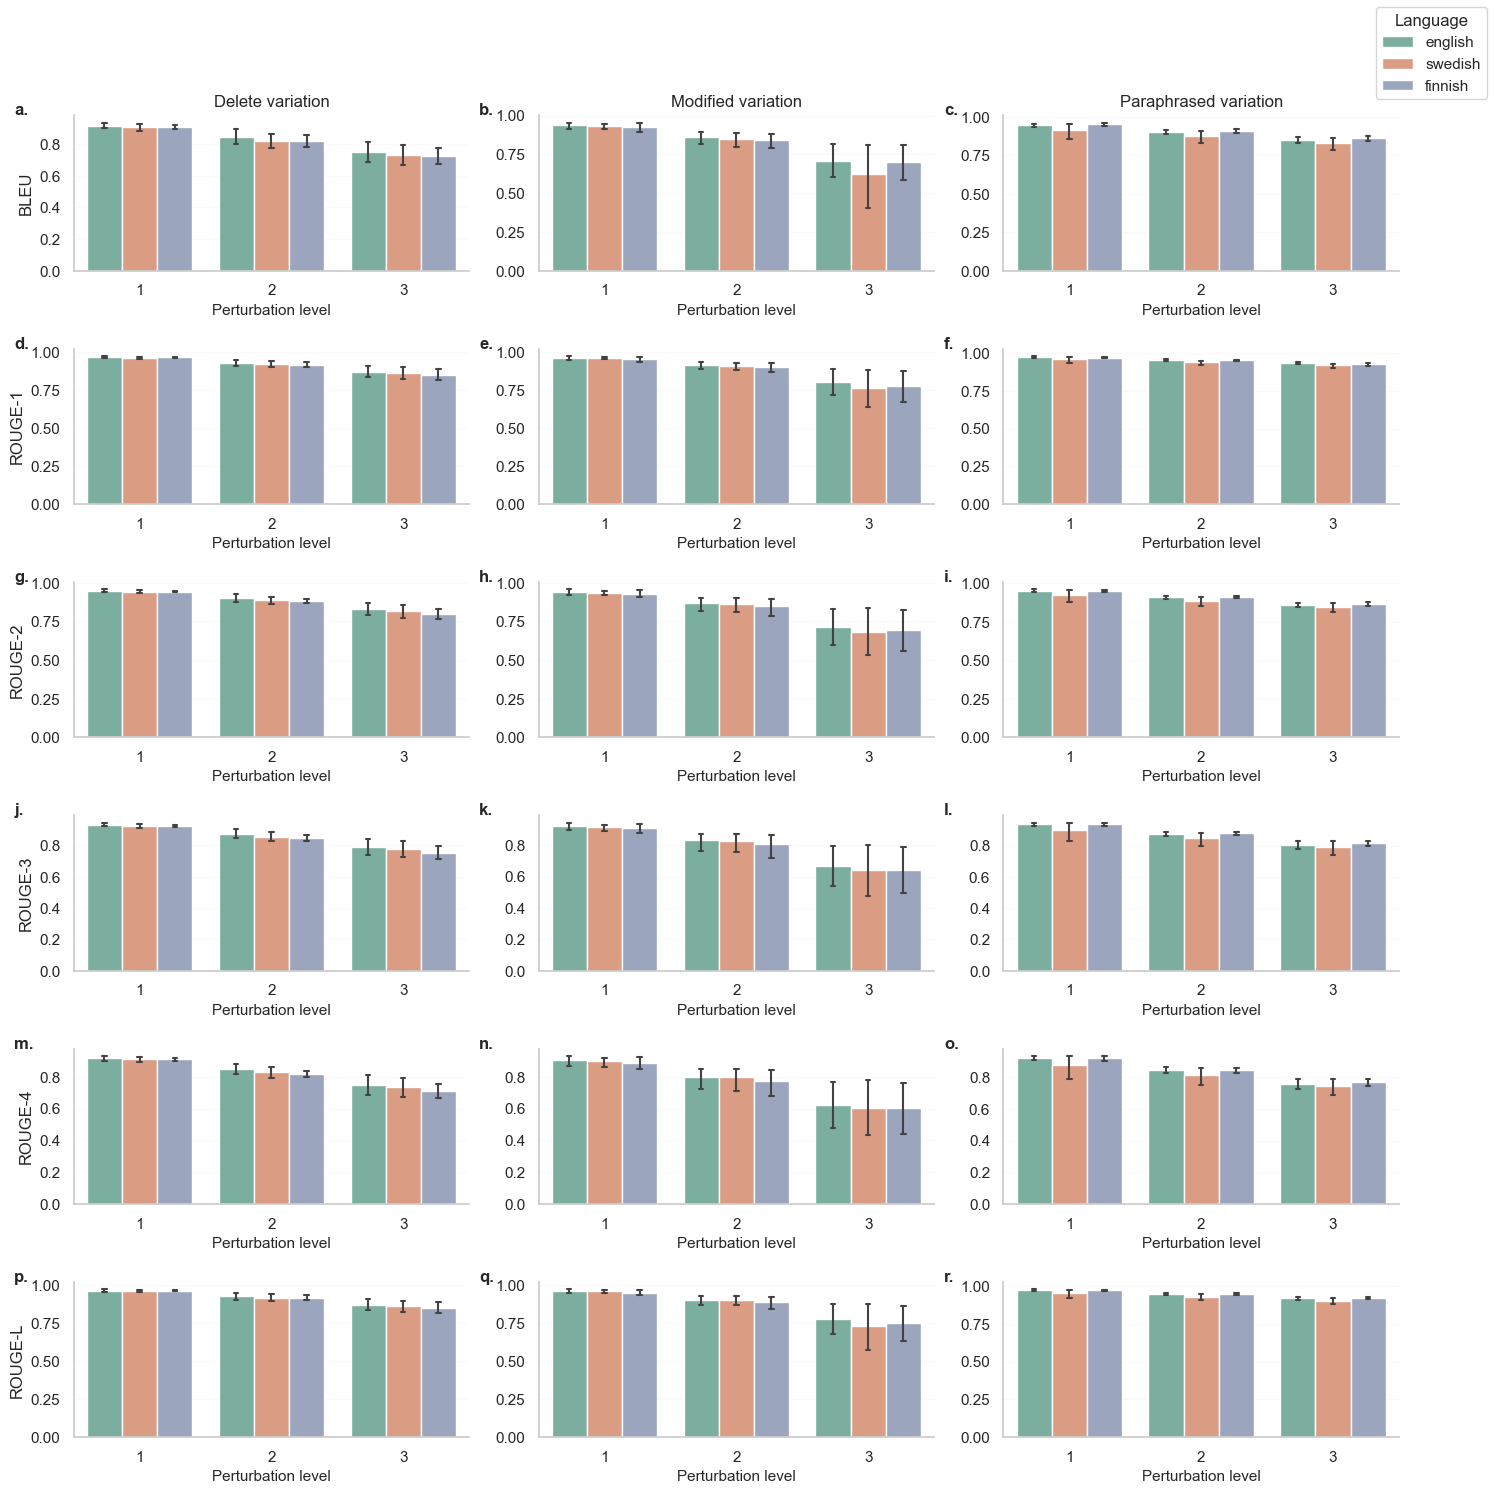

In [12]:
language_palette = {"english": "#73b6a1", "finnish": "#95a3c3", "swedish": "#e99675"}

variation_type_labels = {
    "delete": "Delete",
    "modify": "Modified",
    "synonyms": "Paraphrased",
}
vtypes = ["delete", "modify", "synonyms"]

# Normalize & make levels categorical (1,2,3)
dfp = df_all.copy()
if "variation_type" not in dfp.columns and "type" in dfp.columns:
    dfp = dfp.rename(columns={"type": "variation_type"})
dfp["variation_type"] = dfp["variation_type"].str.lower().replace({"mod": "modify"})
dfp["language"] = dfp["language"].str.lower()
dfp["variation_level"] = pd.to_numeric(dfp["variation_level"], errors="coerce").astype(
    "Int64"
)
dfp = dfp[dfp["variation_level"].notna()]
dfp["level"] = pd.Categorical(
    dfp["variation_level"].astype(int), categories=[1, 2, 3], ordered=True
)

metrics = ["bleu_score", "rouge_1", "rouge_2", "rouge_3", "rouge_4", "rouge_l_score"]
metric_labels = {
    "bleu_score": "BLEU",
    "rouge_1": "ROUGE-1",
    "rouge_2": "ROUGE-2",
    "rouge_3": "ROUGE-3",
    "rouge_4": "ROUGE-4",
    "rouge_l_score": "ROUGE-L",
}

fig, axes = plt.subplots(nrows=len(metrics), ncols=3, figsize=(15, 15), sharey=False)

for r, metric in enumerate(metrics):
    for c, vtype in enumerate(vtypes):
        ax = axes[r, c]
        subset = dfp[dfp["variation_type"] == vtype]

        sns.barplot(
            data=subset,
            x="level",  # <- categorical, fixes the x axis
            y=metric,
            hue="language",
            hue_order=["english", "swedish", "finnish"],
            palette=language_palette,
            ax=ax,
            estimator=np.mean,
            errorbar=("ci", 95),
            err_kws={"linewidth": 1.5},
            capsize=0.1,
        )

        if r == 0:
            ax.set_title(f"{variation_type_labels[vtype]} variation", fontsize=12)
        ax.set_xlabel("Perturbation level", fontsize=11)
        ax.set_ylabel(metric_labels[metric] if c == 0 else "", fontsize=12)

        # no manual xticks needed for categorical x
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(axis="x", visible=False)
        ax.grid(axis="y", linestyle="-", linewidth=0.4, alpha=0.2)

        leg = ax.get_legend()
        if leg:
            leg.remove()

# One shared legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, title="Language", loc="upper right")

# Panel labels a..r
labels = [f"{chr(97 + i)}." for i in range(len(metrics) * 3)]
for ax, lab in zip(axes.flat, labels):
    ax.text(
        -0.15,
        1.08,
        lab,
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
    )

plt.tight_layout(rect=[0, 0, 0.95, 0.95])
fig.savefig(
    f"{BASE}/results/figures/Supplementary_Figure_S1_overlap.svg",
    format="svg",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


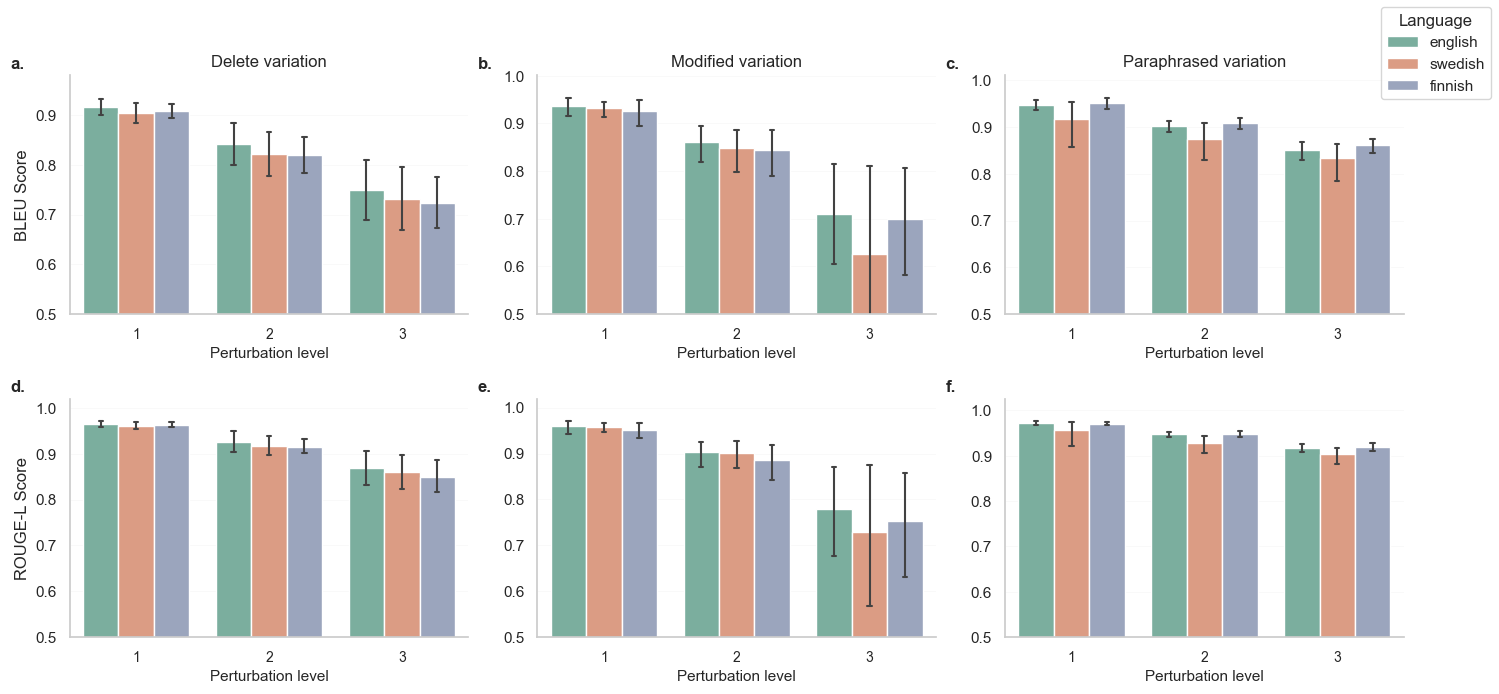

In [13]:
# Human-readable labels
variation_type_labels = {
    "delete": "Delete",
    "modify": "Modified",
    "synonyms": "Paraphrased",
}

# Metrics to plot
metrics = ["bleu_score", "rouge_l_score"]
metric_labels = {"bleu_score": "BLEU Score", "rouge_l_score": "ROUGE-L Score"}

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 7), sharey=False)

for row_idx, metric in enumerate(metrics):
    for col_idx, vtype in enumerate(["delete", "modify", "synonyms"]):
        ax = axes[row_idx, col_idx]
        subset = df_all[df_all["variation_type"] == vtype]

        sns.barplot(
            data=subset,
            x="variation_level",
            y=metric,
            hue="language",
            hue_order=["english", "swedish", "finnish"],
            palette=language_palette,
            ax=ax,
            estimator=np.mean,
            errorbar=("ci", 95),
            err_kws={"linewidth": 1.5},
            capsize=0.1,
        )

        # Formatting
        if row_idx == 0:
            ax.set_title(f"{variation_type_labels[vtype]} variation", fontsize=12)
        if col_idx == 0:
            ax.set_ylabel(metric_labels[metric], fontsize=12)
        else:
            ax.set_ylabel("")

        ax.set_xlabel("Perturbation level", fontsize=11)
        ax.set_ylim(0.5,)
        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels(["1", "2", "3"], fontsize=10)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(axis="x", visible=False)
        ax.grid(axis="y", linestyle="-", linewidth=0.4, alpha=0.2)
        ax.legend_.remove()

# Add common legend and annotations
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, title="Language", loc="upper right")

# Add subplot labels (a., b., c., etc.)
panel_labels = ["a.", "b.", "c.", "d.", "e.", "f."]
for i, ax in enumerate(axes.flat):
    ax.text(
        -0.15,
        1.08,
        panel_labels[i],
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
    )


plt.tight_layout(rect=[0, 0, 0.95, 0.95])
fig.savefig(
    f"{BASE}/results/figures/Figure_2_Overlap.svg",
    format="svg",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


### 3.2. Visualization: Semantic metrics

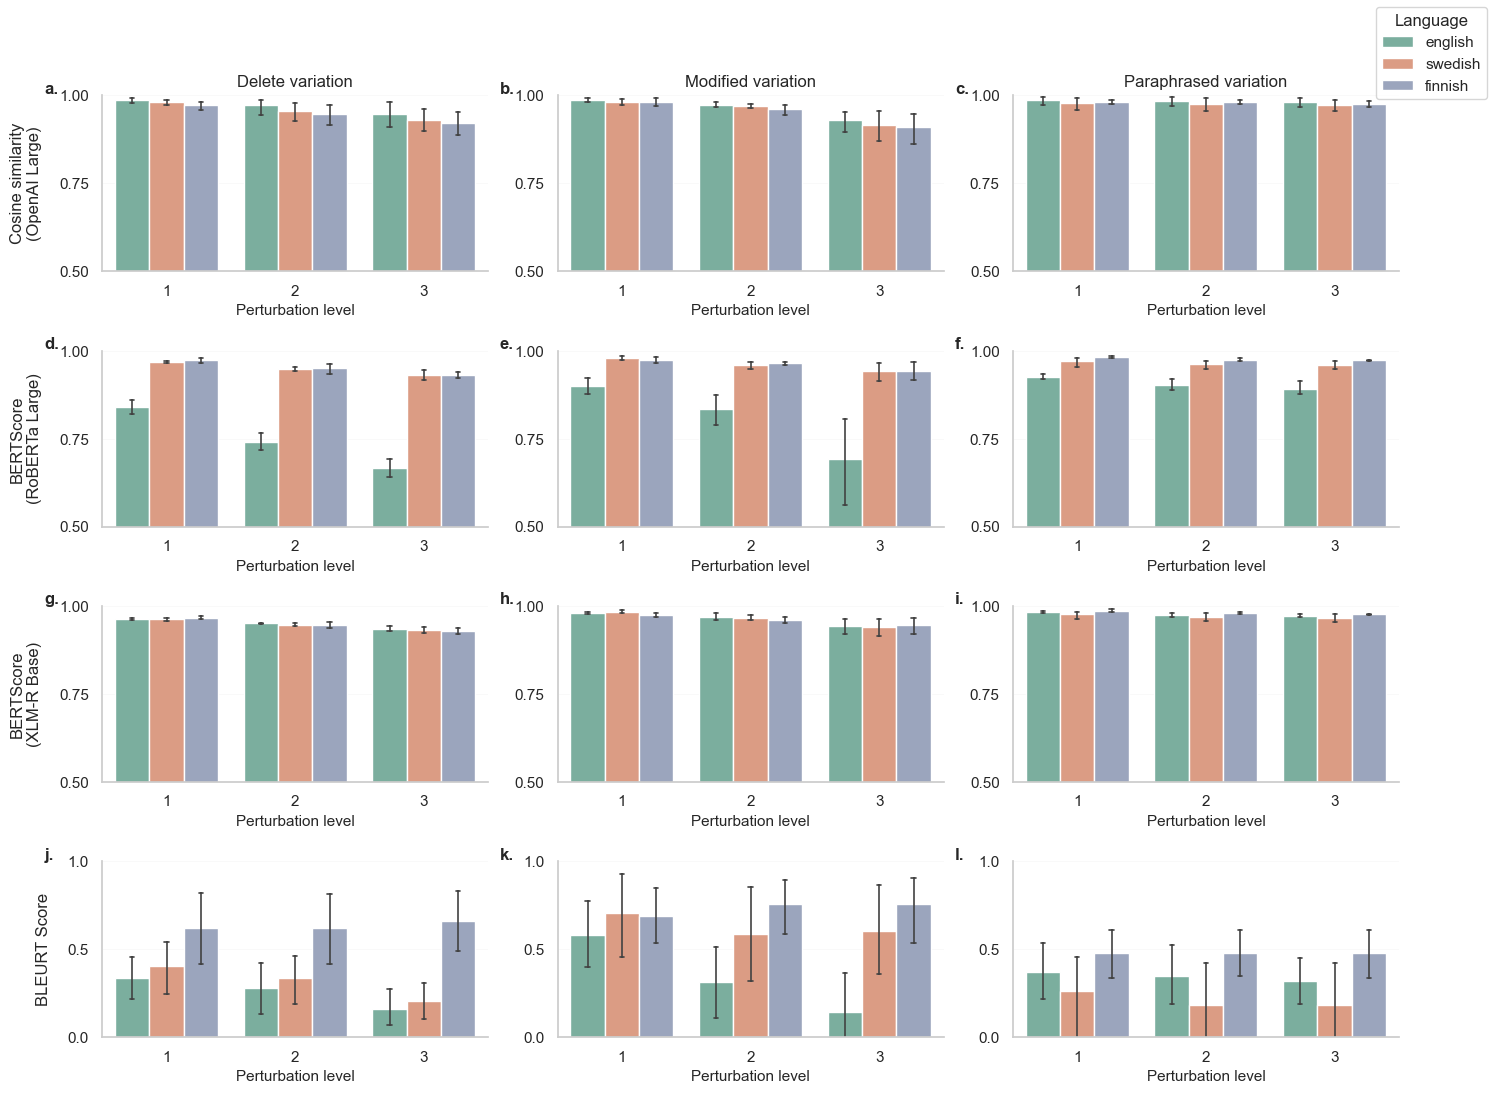

In [14]:
variation_type_labels = {
    "delete": "Delete",
    "modify": "Modified",
    "synonyms": "Paraphrased",
}
vtypes = ["delete", "modify", "synonyms"]

# Normalise columns and levels 
dfp = df_all.copy()
if "variation_type" not in dfp.columns and "type" in dfp.columns:
    dfp = dfp.rename(columns={"type": "variation_type"})

dfp["variation_type"] = dfp["variation_type"].str.lower().replace({"mod": "modify"})
dfp["language"] = dfp["language"].str.lower()

dfp["variation_level"] = pd.to_numeric(dfp["variation_level"], errors="coerce").astype(
    "Int64"
)
dfp = dfp[dfp["variation_level"].notna()]
dfp["level"] = pd.Categorical(
    dfp["variation_level"].astype(int), categories=[1, 2, 3], ordered=True
)

# Ensure a 'model' column and tag cosine similarity rows 
for frame in [df_all, dfp]:
    if "model" not in frame.columns:
        frame["model"] = pd.NA

if "cosine_similarity" in dfp.columns:
    mask_dfp = dfp["cosine_similarity"].notna() & dfp["model"].isna()
    dfp.loc[mask_dfp, "model"] = "OpenAI Large"

if "cosine_similarity" in df_all.columns:
    mask_all = df_all["cosine_similarity"].notna() & df_all["model"].isna()
    df_all.loc[mask_all, "model"] = "OpenAI Large"

# Metrics and labels 
metrics = [
    "cosine_similarity",
    "bertscore_f1__roberta-large",
    "bertscore_f1__xlm-roberta-base",
    "bleurt_score",
]
metric_labels = {
    "cosine_similarity": "Cosine similarity (OpenAI Large)",
    "bertscore_f1__roberta-large": "BERTScore (RoBERTa Large)",
    "bertscore_f1__xlm-roberta-base": "BERTScore (XLM-R Base)",
    "bleurt_score": "BLEURT Score",
}

# Model names on a second line in the y-axis label
metric_labels_2line = {k: v.replace(" (", "\n(") for k, v in metric_labels.items()}


# Single stable figure and axes grid 
nrows, ncols = len(metrics), len(vtypes)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 11), sharey=False)

if nrows == 1:
    axes = np.expand_dims(axes, axis=0)
if ncols == 1:
    axes = np.expand_dims(axes, axis=1)

for r, metric in enumerate(metrics):
    for c, vtype in enumerate(vtypes):
        ax = axes[r, c]
        subset = dfp[dfp["variation_type"] == vtype].copy()

        # For cosine, restrict to the intended backbone to avoid mixing models
        if metric == "cosine_similarity" and "model" in subset.columns:
            subset = subset[subset["model"].astype(str) == "OpenAI Large"]

        if metric not in subset.columns or subset.empty:
            ax.set_visible(False)
            continue

        sns.barplot(
            data=subset,
            x="level",
            y=metric,
            hue="language",
            hue_order=["english", "swedish", "finnish"],
            palette=language_palette,
            ax=ax,
            estimator=np.mean,
            errorbar=("ci", 95),
            err_kws={"linewidth": 1.2},
            capsize=0.1,
        )

        if r == 0:
            ax.set_title(f"{variation_type_labels[vtype]} variation", fontsize=12)

        ax.set_xlabel("Perturbation level", fontsize=11)
        ax.set_ylabel(
            metric_labels_2line[metric] if c == 0 else "",
            fontsize=12,
            labelpad=12,
        )
        ax.yaxis.get_label().set_multialignment("center")

        # Metric-specific y limits
        if metric == "cosine_similarity":
            ax.set_ylim(0.5, 1.0)
            ax.set_yticks([0.5, 0.75, 1.0])
        elif metric == "bertscore_f1__roberta-large":
            ax.set_ylim(0.5, 1.0)
            ax.set_yticks([0.5, 0.75, 1.0])
        elif metric == "bertscore_f1__xlm-roberta-base":
            ax.set_ylim(0.5, 1.0)
            ax.set_yticks([0.5, 0.75, 1.0])
        elif metric == "bleurt_score":
            ax.set_ylim(0.0, 1.0)
            ax.set_yticks([0.0, 0.5, 1.0])

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(axis="x", visible=False)
        ax.grid(axis="y", linestyle="-", linewidth=0.4, alpha=0.2)

        leg = ax.get_legend()
        if leg:
            leg.remove()

# Shared legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, title="Language", loc="upper right")

# Panel labels a..l
labels_seq = [f"{chr(97 + i)}." for i in range(nrows * ncols)]
for ax, lab in zip(axes.flat, labels_seq):
    if ax.get_visible():
        ax.text(
            -0.15,
            1.08,
            lab,
            transform=ax.transAxes,
            fontsize=12,
            fontweight="bold",
            va="top",
        )

plt.tight_layout(rect=[0, 0, 0.95, 0.95])

out_path = f"{BASE}/results/figures/Figure_3_Semantic.svg"
fig.savefig(out_path, format="svg", dpi=300, bbox_inches="tight")
plt.show()


### 3.3. Visualizations - LLM models

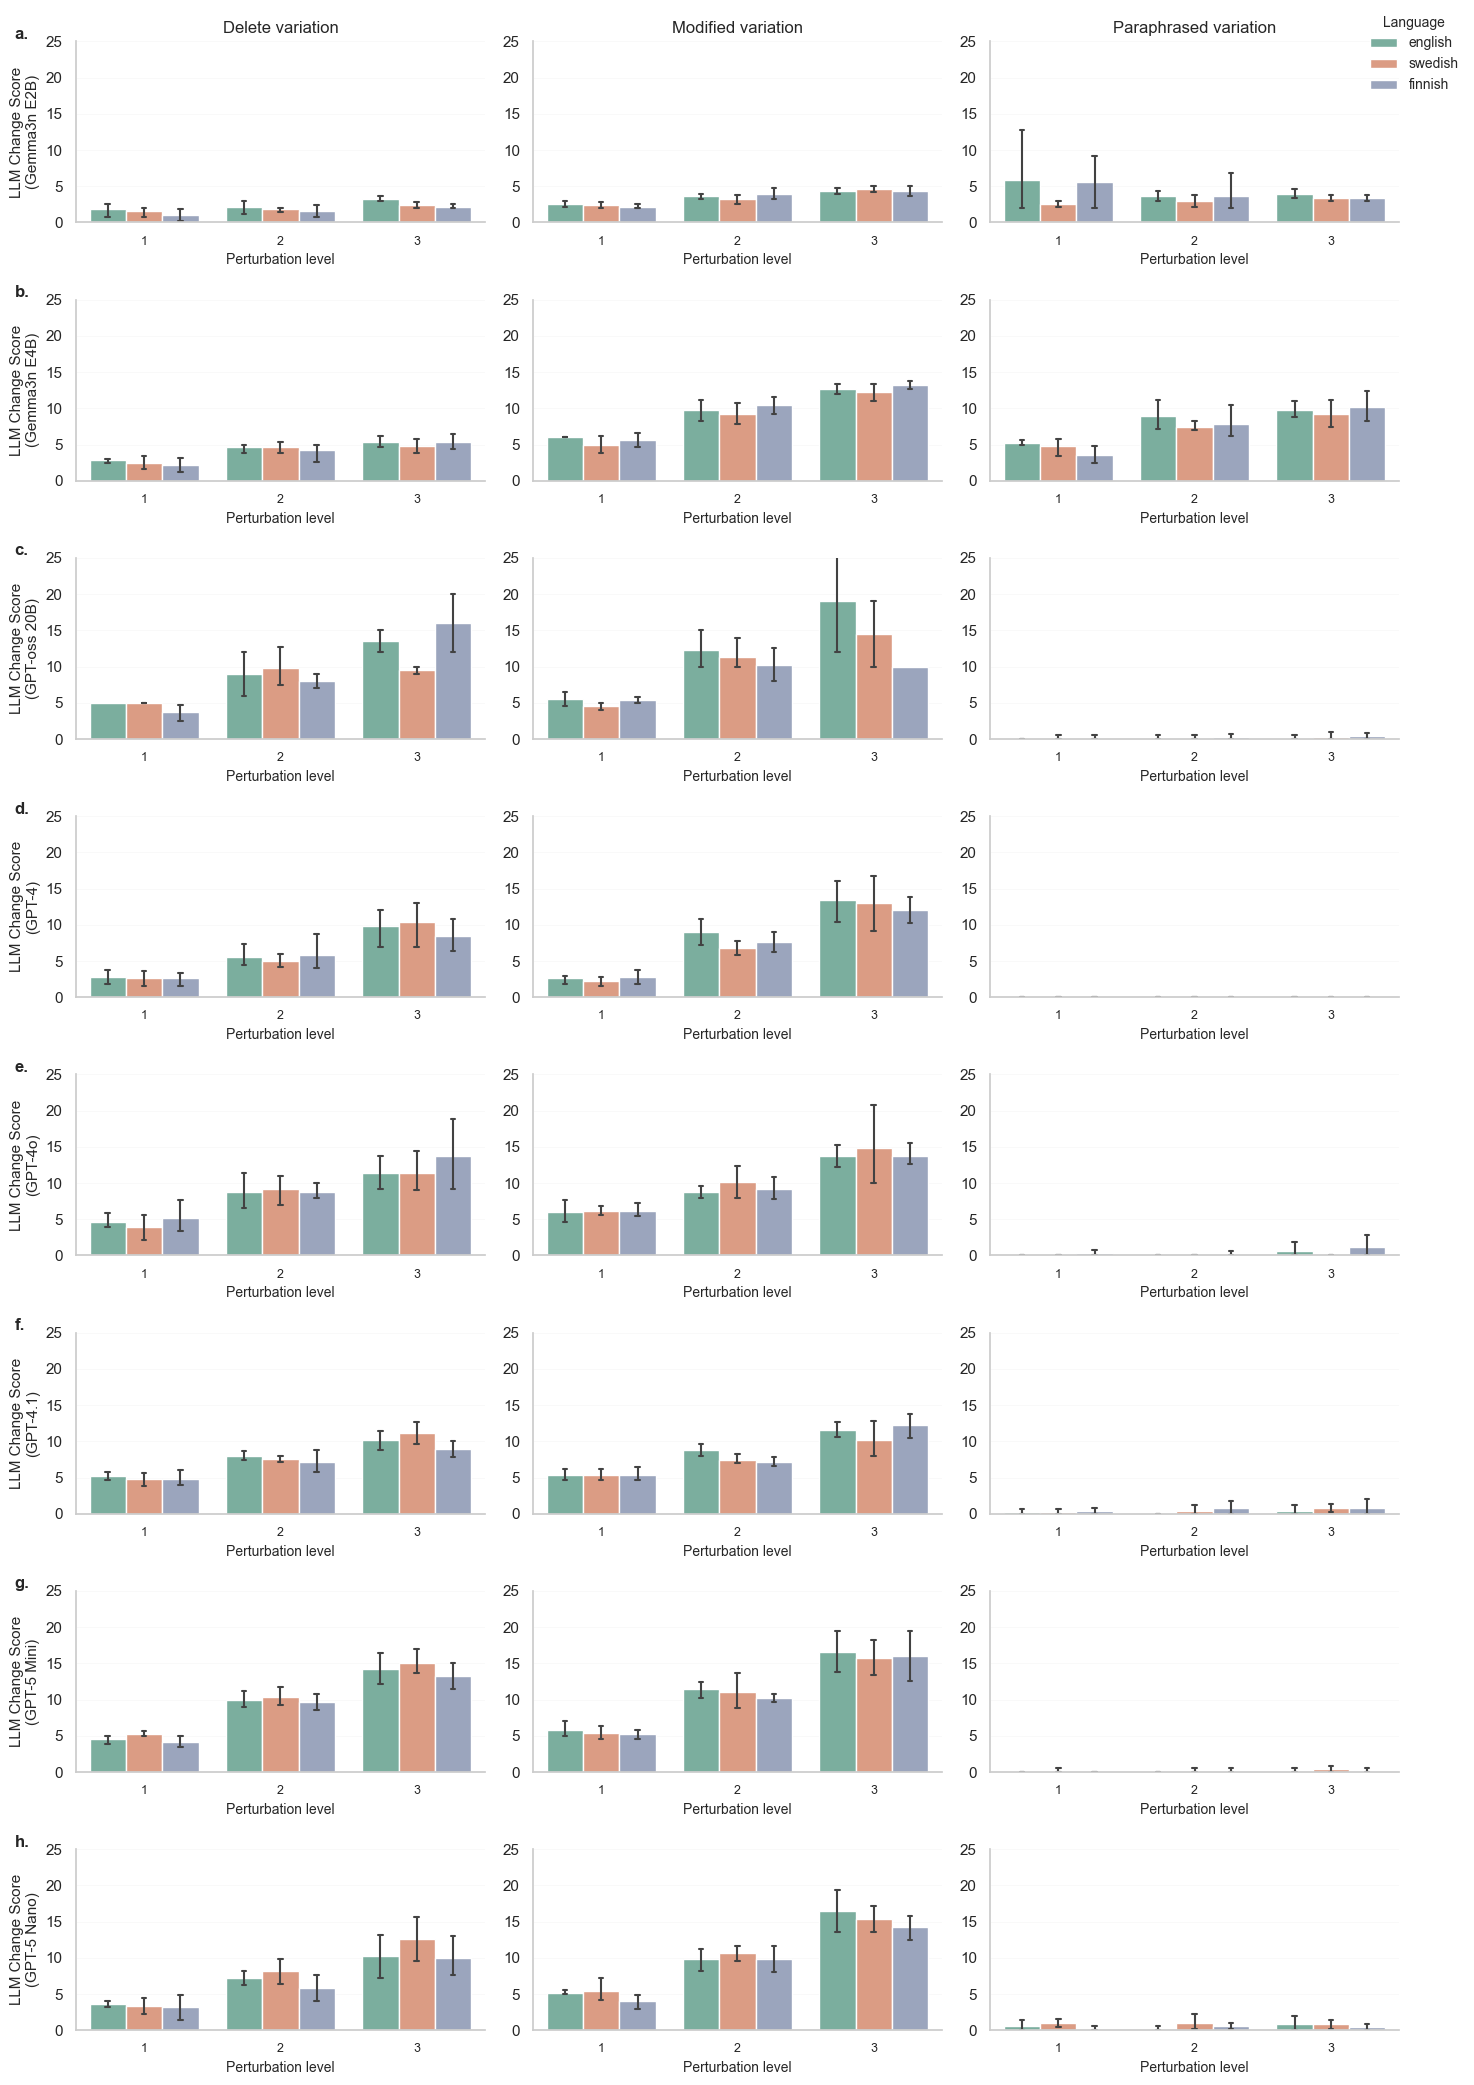

In [15]:
variation_title_map = {
    "delete": "Delete",
    "modify": "Modified",
    "synonyms": "Paraphrased",
}

# LLMs included
llm_cols = [
    "Gemma3n E2B",
    "Gemma3n E4B",
    "gpt-oss-20b",
    "gpt 4", 
    "gpt-4o",
    "gpt-4.1",
    "gpt-5 mini",
    "gpt-5 nano",
]

# Nice labels
model_label_map = {
    "Gemma3n E2B": "Gemma3n E2B",
    "Gemma3n E4B": "Gemma3n E4B",
    "gpt-oss-20b": "GPT-oss 20B",
    "gpt 4": "GPT-4",
    "gpt-4o": "GPT-4o",
    "gpt-4.1": "GPT-4.1",
    "gpt-5 mini": "GPT-5 Mini",
    "gpt-5 nano": "GPT-5 Nano",
}

# Prepare dataframe
llm_df = df_all[["language", "variation_type", "variation_level"] + llm_cols].copy()
llm_df = llm_df.dropna(
    subset=llm_cols, how="all"
)  # Keep rows with at least one LLM score

# Melt long
llm_melted = llm_df.melt(
    id_vars=["language", "variation_type", "variation_level"],
    value_vars=llm_cols,
    var_name="llm_model",
    value_name="llm_change_score",
)

# Filter only available models
available_models = llm_melted["llm_model"].dropna().unique()
row_model_order = [m for m in llm_cols if m in available_models]
n_rows = len(row_model_order)
n_cols = 3  # One per variation type

# Create subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 22), sharey=False)
if n_rows == 1:
    axes = np.array([axes])  # ensure it's 2D for consistent indexing

panel_labels = list(string.ascii_lowercase)

for row_idx, llm_model in enumerate(row_model_order):
    for col_idx, vtype in enumerate(["delete", "modify", "synonyms"]):
        ax = axes[row_idx, col_idx]
        subset = llm_melted[
            (llm_melted["llm_model"] == llm_model)
            & (llm_melted["variation_type"] == vtype)
        ]

        sns.barplot(
            data=subset,
            x="variation_level",
            y="llm_change_score",
            hue="language",
            hue_order=["english", "swedish", "finnish"],
            palette=language_palette,
            ax=ax,
            estimator=np.mean,
            errorbar=("ci", 95),
            err_kws={"linewidth": 1.5},
            capsize=0.1,
        )

        # Force y-axis range 0–25
        ax.set_ylim(0, 25)
        ax.set_yticks(np.arange(0, 26, 5))

        if row_idx == 0:
            ax.set_title(f"{variation_title_map[vtype]} variation", fontsize=12)
        if col_idx == 0:
            ax.set_ylabel(
                f"LLM Change Score\n({model_label_map.get(llm_model, llm_model)})",
                fontsize=11,
            )
        else:
            ax.set_ylabel("")

        ax.set_xlabel("Perturbation level", fontsize=10)
        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels(["1", "2", "3"], fontsize=9)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(axis="x", visible=False)
        ax.grid(axis="y", linestyle="-", linewidth=0.4, alpha=0.2)
        ax.legend_.remove()

        # Only label the first column in each row
        if col_idx == 0:
            ax.text(
                -0.15,
                1.08,
                f"{panel_labels[row_idx]}.",
                transform=ax.transAxes,
                fontsize=12,
                fontweight="bold",
                va="top",
            )

# Add one legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="Language",
    loc="upper left",  # try "upper left" or "center right"
    bbox_to_anchor=(0.91, 0.95),  # x, y position in figure coordinates
    fontsize=10,
    title_fontsize=10,
    frameon=False,
)

plt.tight_layout(rect=[0, 0, 0.95, 0.95])
fig.savefig(
    f"{BASE}/results/figures/Supplementary_Figure_S2_LLMs.svg",
    format="svg",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


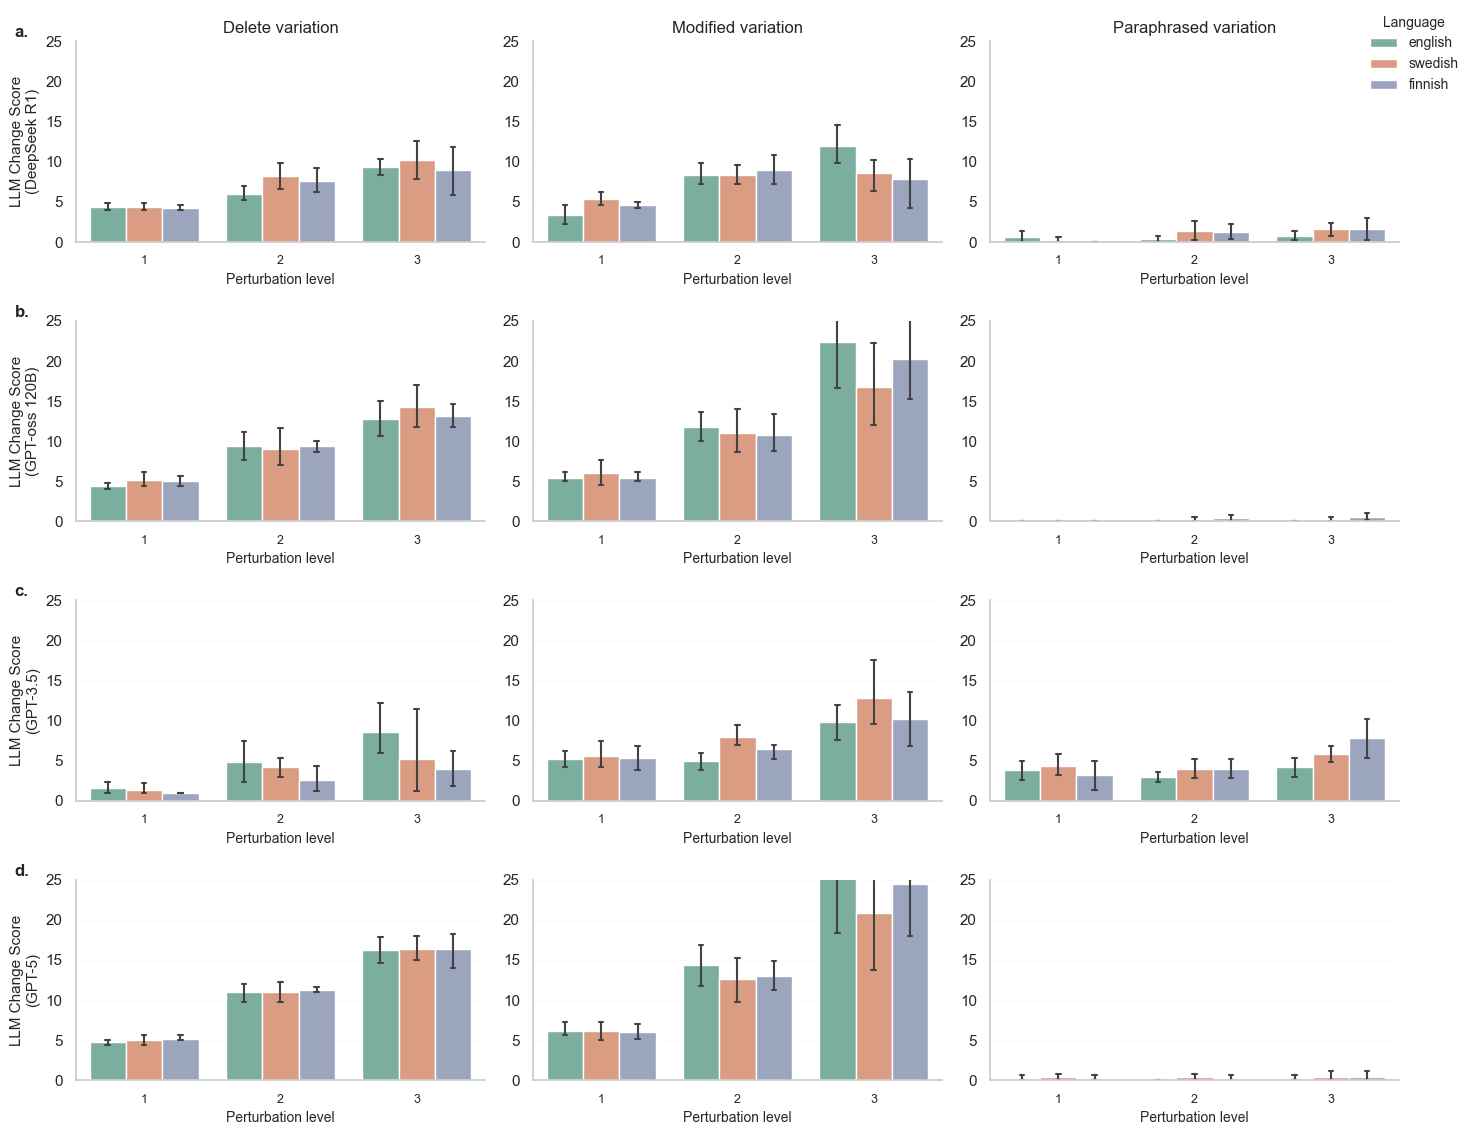

In [16]:
variation_title_map = {
    "delete": "Delete",
    "modify": "Modified",
    "synonyms": "Paraphrased",
}

# LLMs one want
llm_cols = [
    "DeepSeek R1",
    "gpt-oss-120b",
    "gpt 3.5",
    "gpt-5",
]

# Nice labels
model_label_map = {
    "DeepSeek R1": "DeepSeek R1",
    "gpt-oss-120b": "GPT-oss 120B",
    "gpt 3.5": "GPT-3.5",
    "gpt-5": "GPT-5",
}

# Prepare dataframe
llm_df = df_all[["language", "variation_type", "variation_level"] + llm_cols].copy()
llm_df = llm_df.dropna(
    subset=llm_cols, how="all"
)  # Keep rows with at least one LLM score

# Melt long
llm_melted = llm_df.melt(
    id_vars=["language", "variation_type", "variation_level"],
    value_vars=llm_cols,
    var_name="llm_model",
    value_name="llm_change_score",
)

# Filter only available models
available_models = llm_melted["llm_model"].dropna().unique()
row_model_order = [m for m in llm_cols if m in available_models]
n_rows = len(row_model_order)
n_cols = 3  # One per variation type

# Create subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 12), sharey=False)
if n_rows == 1:
    axes = np.array([axes])  # ensure it's 2D for consistent indexing

panel_labels = list(string.ascii_lowercase)

for row_idx, llm_model in enumerate(row_model_order):
    for col_idx, vtype in enumerate(["delete", "modify", "synonyms"]):
        ax = axes[row_idx, col_idx]
        subset = llm_melted[
            (llm_melted["llm_model"] == llm_model)
            & (llm_melted["variation_type"] == vtype)
        ]

        sns.barplot(
            data=subset,
            x="variation_level",
            y="llm_change_score",
            hue="language",
            hue_order=["english", "swedish", "finnish"],
            palette=language_palette,
            ax=ax,
            estimator=np.mean,
            errorbar=("ci", 95),
            err_kws={"linewidth": 1.5},
            capsize=0.1,
        )

        # Force y-axis range 0–25
        ax.set_ylim(0, 25)
        ax.set_yticks(np.arange(0, 26, 5))

        if row_idx == 0:
            ax.set_title(f"{variation_title_map[vtype]} variation", fontsize=12)
        if col_idx == 0:
            ax.set_ylabel(
                f"LLM Change Score\n({model_label_map.get(llm_model, llm_model)})",
                fontsize=11,
            )
        else:
            ax.set_ylabel("")

        ax.set_xlabel("Perturbation level", fontsize=10)
        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels(["1", "2", "3"], fontsize=9)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(axis="x", visible=False)
        ax.grid(axis="y", linestyle="-", linewidth=0.4, alpha=0.2)
        ax.legend_.remove()

        # Only label the first column in each row
        if col_idx == 0:
            ax.text(
                -0.15,
                1.08,
                f"{panel_labels[row_idx]}.",
                transform=ax.transAxes,
                fontsize=12,
                fontweight="bold",
                va="top",
            )

# Add one legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="Language",
    loc="upper left",  # try "upper left" or "center right"
    bbox_to_anchor=(0.91, 0.95),  # x, y position in figure coordinates
    fontsize=10,
    title_fontsize=10,
    frameon=False,
)

plt.tight_layout(rect=[0, 0, 0.95, 0.95])
fig.savefig(
    f"{BASE}/results/figures/Figure_4_LLMs.svg",
    format="svg",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

## 4. Correlations (Pearsons P)

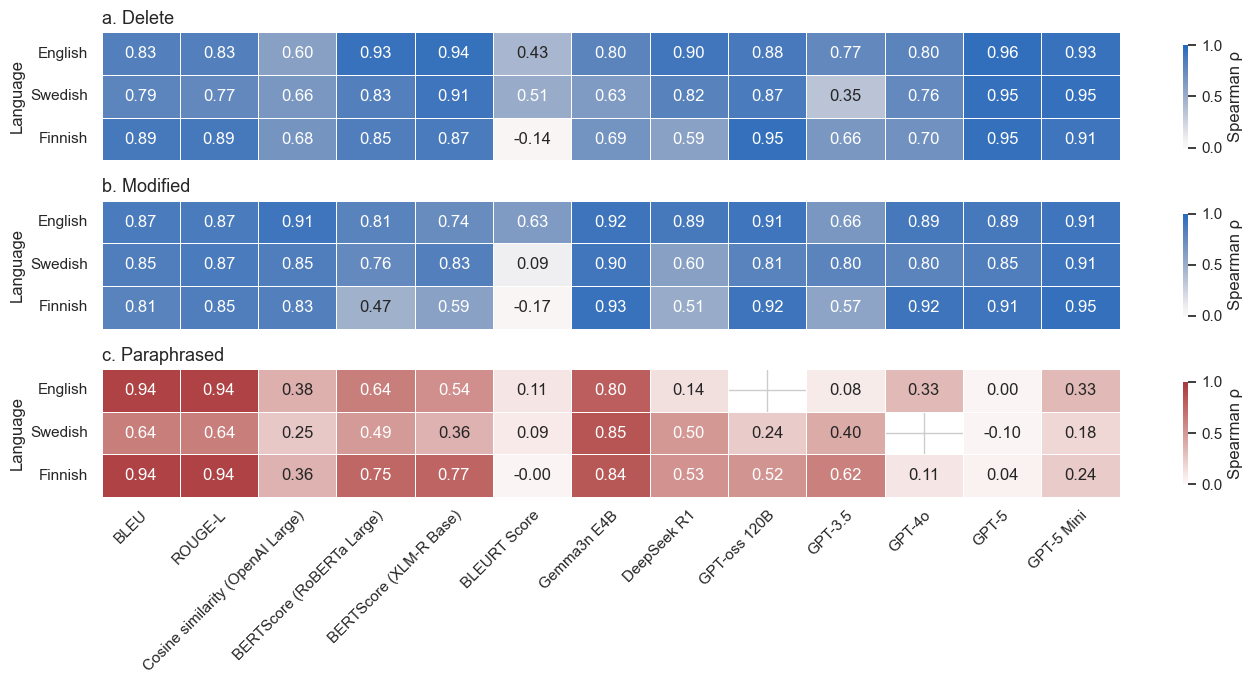

In [17]:
from scipy.stats import spearmanr

# Define positive metrics
positive_metrics = [
    "Gemma3n E4B",
    "DeepSeek R1",
    "gpt-oss-120b",
    "gpt 3.5",
    "gpt-4o",
    "gpt-5",
    "gpt-5 mini",
]

# Define metric order and display names
ordered_metrics = [
    "bleu_score",
    "rouge_l_score",
    "cosine_similarity",
    "bertscore_f1__roberta-large",
    "bertscore_f1__xlm-roberta-base",
    "bleurt_score",
    "Gemma3n E4B",
    "DeepSeek R1",
    "gpt-oss-120b",
    "gpt 3.5",
    "gpt-4o",
    "gpt-5",
    "gpt-5 mini",
]

metric_display = {
    "bleu_score": "BLEU",
    "rouge_l_score": "ROUGE-L",
    "cosine_similarity": "Cosine similarity (OpenAI Large)",
    "bertscore_f1__roberta-large": "BERTScore (RoBERTa Large)",
    "bertscore_f1__xlm-roberta-base": "BERTScore (XLM-R Base)",
    "bleurt_score": "BLEURT Score",
    "Gemma3n E4B": "Gemma3n E4B",
    "DeepSeek R1": "DeepSeek R1",
    "gpt-oss-120b": "GPT-oss 120B",
    "gpt 3.5": "GPT-3.5",
    "gpt-4o": "GPT-4o",
    "gpt-5": "GPT-5",
    "gpt-5 mini": "GPT-5 Mini",
}

# Filter data for model
df = df_all[df_all["model"] == "OpenAI Large"].copy()

# Add variation_group based on actual type
df["variation_group"] = df["variation_type"].map(
    {"delete": "Delete", "modify": "Modified", "synonyms": "Paraphrased"}
)

# Compute Spearman ρ
results = []
for lang in df["language"].unique():
    for group in ["Delete", "Modified", "Paraphrased"]:
        subset = df[(df["language"] == lang) & (df["variation_group"] == group)]
        row = {"Language": lang.title(), "Variation Group": group}
        for metric in ordered_metrics:
            data = subset[[metric, "variation_level"]].dropna()
            if data[metric].nunique() <= 1:
                row[metric_display[metric]] = None
                continue
            rho, _ = spearmanr(data["variation_level"], data[metric])
            if metric not in positive_metrics:
                rho *= -1
            row[metric_display[metric]] = round(rho, 2)
        results.append(row)

# Create DataFrame
heatmap_df = pd.DataFrame(results)

# Plot heatmaps vertically
fig, axes = plt.subplots(3, 1, figsize=(14, 7), sharex=True)

variation_order = ["Delete", "Modified", "Paraphrased"]
titles = ["a. Delete", "b. Modified", "c. Paraphrased"]

# Desired language order
language_order = ["English", "Swedish", "Finnish"]

for i, group in enumerate(variation_order):
    plot_df = heatmap_df[heatmap_df["Variation Group"] == group].set_index("Language")
    plot_df = plot_df.drop(columns=["Variation Group"])
    plot_df = plot_df[
        [
            metric_display[m]
            for m in ordered_metrics
            if metric_display[m] in plot_df.columns
        ]
    ]

    # Reindex to enforce consistent language order
    plot_df = plot_df.reindex(language_order)

    sns.heatmap(
        plot_df,
        annot=True,
        cmap="vlag_r" if group in ["Delete", "Modified"] else "vlag",
        center=0,
        vmin=0,
        vmax=1,
        fmt=".2f",
        linewidths=0.5,
        cbar_kws={"shrink": 0.8, "label": "Spearman ρ"},
        ax=axes[i],
    )
    axes[i].set_title(titles[i], loc="left", fontsize=13)
    # x-labels: show only on the bottom heatmap, at 45°
    if i < len(axes) - 1:
        axes[i].set_xticklabels([])
    else:
        axes[i].set_xticklabels(
            axes[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor"
        )
        axes[i].tick_params(axis="x", which="major", pad=2)


plt.tight_layout()
plt.savefig(
    f"{BASE}/results/figures/Supplementary_Figure_S3_Spearman.svg",
    format="svg",
    dpi=300,
    bbox_inches="tight",
)
plt.show()